In [84]:
import numpy as np

Ns=20#only even numbers
N, PBC = 4, False
J, U,V = 1,40,-1.97
maxOcc = min(N,5)
fraction = 0.99
#phi0 = np.loadtxt('./dataLogEstimation/%d_%d_%.2f_%.2f_%.3f_%d.txt'%(Ns,N,U,V,fraction,maxOcc))
#phi0/= np.sqrt(sum(sum(abs(phi0)**2)))

phi0 = np.load(("../jastrowdecomped/Ns%i_N%i_J%f_U%f_V%f_OBC.npy"%(Ns,N,J,U,V)))
phi /= sum(sum(abs(phi0)**2))
G1DMRG = np.loadtxt('G1.txt')
G2DMRG = np.loadtxt('G2.txt')

def normCoef(_xs):
    # fock = np.zeros(Ns,dtype=int)
    # for x in _xs:
    #     fock[x]+=1
    # out = np.math.factorial(N)
    # for n in fock:
    #     out/=np.math.factorial(n)
    # return np.sqrt(1/out)
    return 1

def psi(_xs,_phi):
    out = 1
    for i in range(len(_xs)):
        for j in range(i+1,len(_xs)):
            out *= _phi[_xs[i],_xs[j]]
    return normCoef(_xs)*out

def d(x):
    if abs(x)<1e-6:
        return 1
    return 0

In [86]:
######################################################################
def computeElemWK(x,xp, _phi):
    out = 0
    for x2 in range(0,Ns):
        for x3 in range(0,Ns):
            for x4 in range(Ns):
                out += (N-1) * d(x+1-x2) * psi([x,xp,x3,x4], _phi)*psi([x2,xp,x3,x4], _phi)
                out += (N-1) * d(xp-1-x2) * psi([x2,x,x3,x4], _phi)*psi([xp,x,x3,x4], _phi)
                out += (N-1)*(N-2) * d(x2+1-x3) * psi([x2,x,xp,x4], _phi)*psi([x3,x,xp,x4], _phi)
    return out/_phi[x,xp]

def computeWK():
    out = np.zeros((Ns,Ns),float) 
    for x in range(Ns):
        for xp in range(x,Ns):
            out[x,xp] = computeElemWK(x,xp, phi0)
            out[xp,x] = out[x,xp]
    return out
            
######################################################################  
def computeElemWU(x,xp, _phi):
    out = 0
    for x3 in range(0,Ns):
        for x4 in range(0,Ns):
            out += 2 * d(x-xp) * abs(psi([x,xp,x3,x4], phi0))**2
            out += 2*(N-2) * d(x-x3)* abs(psi([x,xp,x3,x4], phi0))**2
            out += 2*(N-2) * d(xp-x3) * abs(psi([x,xp,x3,x4], phi0))**2
            out += (N-2)*(N-3) * d(x3-x4) * abs(psi([x,xp,x3,x4], phi0))**2
    return out/_phi[x,xp]

def computeWU():
    out = np.zeros((Ns,Ns),float) 
    for x in range(Ns):
        for xp in range(x,Ns):
            out[x,xp] = computeElemWU(x,xp, phi0)
            out[xp,x] = out[x,xp]
    return out
            
######################################################################  
def computeElemWV(x,xp, _phi):
    out = 0
    for x3 in range(0,Ns):
        for x4 in range(0,Ns):
            if _phi[x,xp] != 0:
                out += 2 * d(x+1-xp) * abs(psi([x,xp,x3,x4], phi0))**2
                out += 2*(N-2)*  ( d(x+1-x3)+d(xp-1-x3) ) * abs(psi([x,xp,x3,x4], phi0))**2
                out += (N-2)*(N-3) * d(x3+1-x4) * abs(psi([x,xp,x3,x4], phi0))**2
    return out/_phi[x,xp]

def computeWV():
    out = np.zeros((Ns,Ns),float) 
    for x in range(Ns):
        for xp in range(x,Ns):
            out[x,xp] = computeElemWV(x,xp, phi0)
            out[xp,x] = out[x,xp]
    return out
###################################################################### 
W = -2*computeWK() 
W += 0.5*U*computeWU() 
W += V*computeWV()
phi = W/np.sqrt(sum(sum(abs(W)**2)))


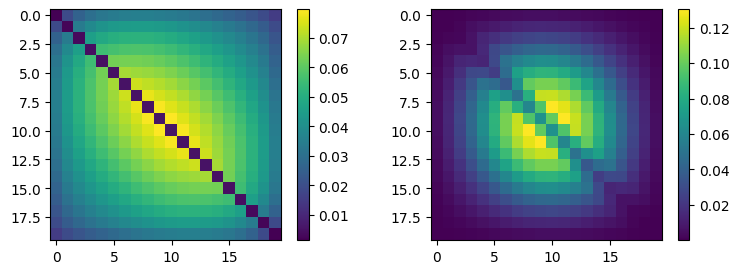

In [87]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=[9,3])
cmap = ax[0].imshow(phi0)
plt.colorbar(cmap)
cmap = ax[1].imshow(-phi)
plt.colorbar(cmap)
plt.show()

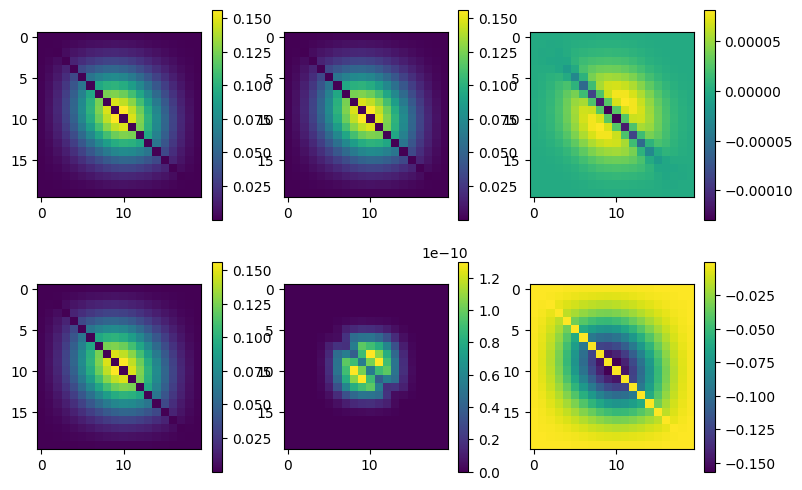

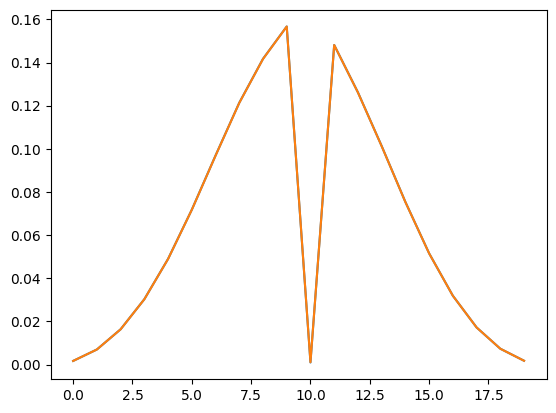

In [88]:
G2phi0 = np.zeros((Ns,Ns),dtype=float)
G2phi = np.zeros((Ns,Ns),dtype=float)

for x in range(Ns):
    for xp in range(0,Ns):
        for x3 in range(0,Ns):
            for x4 in range(0,Ns):
                G2phi0[x,xp] += abs(psi([x,xp,x3,x4], phi0))**2
                G2phi[x,xp] += abs(psi([x,xp,x3,x4], phi))**2
                
G2phi0 *= G2DMRG[4,5]/G2phi0[4,5]
fig,ax = plt.subplots(2,3,figsize=[9,6])

cm = ax[0,0].imshow(G2DMRG)
plt.colorbar(cm)
cm = ax[0,1].imshow(G2phi0)
plt.colorbar(cm)
cm = ax[0,2].imshow(G2phi0-G2DMRG)
plt.colorbar(cm)

cm = ax[1,0].imshow(G2DMRG)
plt.colorbar(cm)
cm = ax[1,1].imshow(G2phi)
plt.colorbar(cm)
cm = ax[1,2].imshow(G2phi-G2DMRG)
plt.colorbar(cm)
#plt.imshow(G1DMRG)
plt.show()
plt.plot([G2phi0[10,x] for x in range(Ns)])
plt.plot([G2DMRG[10,x] for x in range(Ns)])

In [89]:
from numpy import zeros, sqrt, linalg, array, ones, exp, eye, copy,sign,real,imag,transpose,log,average, var, conj, math, var,append, save
import matplotlib.pyplot as plt
from random import randint
from scipy.sparse import lil_matrix
from scipy.optimize import basinhopping, dual_annealing, shgo, direct, brute, differential_evolution, minimize
from scipy.sparse.linalg import eigsh
import time

def genBase(js_,N_,base_,baseQ1_):
    if N_==0:
        base_.append( [0]*Ns )
        for j in js_:
            base_[-1][j]+=1
        baseQ1_.append([x for x in js_])
    else:
        leftBound = 0
        if len(js_)>0:
            leftBound = js_[-1]
        for j in range(leftBound,Ns):
            genBase(js_+[j],N_-1,base_,baseQ1_)
        
base, baseQ1 = [], []
base1, base1Q1 = [],[]
base2, base2Q1= [],[]

genBase([],1,base1,base1Q1)
genBase([],2,base2,base2Q1)
genBase([],N,base,baseQ1)

#for i in range(len(base)):
#    print(base[i],base2[i],array(base[i])-array(base2[i]))

NoS1, NoS2, NoS = len(base1), len(base2), len(base)
print('Number of base states =',NoS)

Number of base states = 8855


In [90]:
#################################################################
##Compute energy and the GS of H for choosen N ##################
#################################################################
def normalised(arr):
    return arr / sqrt(sum(abs(arr)**2))

def generateHamitlonian(base_, J_,U_,V_):
    NoS = len(base_)
    H = lil_matrix((NoS,NoS),dtype=float)
    for i in range(NoS):
        sL = base_[i]
        for j in range(0,Ns-1):
            if sL[j]>0:
                coef = -J_*sqrt(sL[j])*sqrt(sL[j+1]+1)
                sR = [x for x in sL]
                sR[j]-=1
                sR[j+1]+=1
                ip = base_.index(sR)
                H[i,ip]+=coef
                H[ip,i]+=coef
        if PBC:     
            if sL[Ns-1]>0:
                coef = -J_*sqrt(sL[Ns-1])*sqrt(sL[0]+1)
                sR = [x for x in sL]
                sR[Ns-1]-=1
                sR[0]+=1
                ip = base_.index(sR)
                H[i,ip]+=coef
                H[ip,i]+=coef
        coefU = 0.0
        for j in range(0,Ns):
            coefU += 0.5*U_*sL[j]*(sL[j]-1)
        H[i,i] += coefU
        coefV = 0.0
        for j in range(0,Ns-1):
            coefV += V_*sL[j]*sL[j+1]
        if PBC:  
            coefV += V_*sL[Ns-1]*sL[0]
        H[i,i] += coefV
    return H

print("Computing reference GS...",end='')
t0 = time.time()

H_1atom = generateHamitlonian(base1, J,U,V)
E, v = eigsh(H_1atom,k=1,which='SA')  
E_1atom = E[0]
GS_1atom = sign(v[0,0])*v[:,0]

H_2atom = generateHamitlonian(base2, J,U,V)
E, v = eigsh(H_2atom,k=1,which='SA')  
E_2atom = E[0]
GS_2atom = sign(v[0,0])*v[:,0]
#print(H_2atom)
H = generateHamitlonian(base, J,U,V)
E, v = eigsh(H,k=1,which='SA')  
E_R = E[0]
GS = sign(v[0,0])*v[:,0]

#print()
#for i in range(len(base)):
#    print(base2[i],GS_2atom[i])

#print(GS_2atom)
#plt.imshow(real(reshapePhiTo2D([float(i) for i in GS_2atom])))

print(" DONE in ",(time.time()-t0)*1000,"[ms]")

Computing reference GS... DONE in  2368.9515590667725 [ms]


In [91]:
def secondToFirst(state):
    baseState = state.copy()
    js = [0]*N
    for i in range(N):
        for n in range(Ns):
            if baseState[n]>0:
                js[i]=n
                baseState[n]-=1
                break
    return js

def norm(fock):
    out = math.factorial(N)
    for n in range(Ns):
        out /= math.factorial(fock[n])
    return sqrt(out)

def energy(c):
    return sum(real(conj(c)*H*c))

def getNis(c):
    out = zeros(Ns)
    for i in range(NoS):
        out += abs(c[i])**2*array(base[i])
    return out   

def getG2sX(c,x):
    G2s = zeros(Ns,dtype=complex)
    for i in range(NoS):
        fock = base[i]
        for xp in range(Ns):
            G2s[xp] += abs(c[i])**2*fock[x]*fock[xp]
            if x==xp:
                G2s[xp] -= abs(c[i])**2*fock[x]
    return G2s  

In [70]:
A1 = zeros([NoS,int((Ns+1)/2)],dtype=int)

for i in range(NoS):
    A1[i] = array(base[i][0:int((Ns+1)/2)])  + array(base[i][Ns:int((Ns-1)/2):-1])
        
#########################333####################################################################
combs = []
for n in range(Ns):
    for n2 in range(n, Ns):
        combs.append([n,n2])
        
combsh = []
for n in range(Ns):
    for n2 in range(n, Ns):
        if n+n2 < Ns:
            combsh.append([n,n2])

def P(fockState):
    js = secondToFirst(fockState)
    out = zeros(int(Ns*(Ns+1)/2),dtype=int)
    for n in range(N):
        for np in range(n+1,N):
            out[combs.index([js[n],js[np]])]+=1
    return out

def Ph(fockState):
    js = secondToFirst(fockState)
    out = zeros(len(combsh),dtype=int)
    for n in range(N):
        for np in range(n+1,N):
            ind1 = js[n]
            ind2 = js[np]
            if js[n]+js[np] >= Ns:
                ind1 -= (js[n]+js[np]-Ns+1)
                ind2 -= (js[n]+js[np]-Ns+1)    
            out[combsh.index([ind1,ind2])]+=1
    return out

A2 = zeros([NoS,len(combs)],dtype=int)
A2h = zeros([NoS,len(combsh)],dtype=int)


for i in range(NoS):
    A2[i] = P(base[i])
    A2h[i] = Ph(base[i])
#print(A2)    
#for i in range(len(base)):
#    print(GS_2atom[i],exp(A2.dot(log(GS_2atom,dtype=complex)))[i],Norms1[i])
#print()
def psi12to14(psi12):
    out = []
    num =0
    for comb in combs:
        if comb[0]+comb[1]< Ns:
            out.append(psi12[num])
        num+=1
    return array(out)

def psi11topsi12(psi):
    out = []
    num =0
    for x in range(0,Ns):
        for xp in range(x,Ns):
            out.append(psi[x,xp])
    return array(out)

def psi14to12(psi14):
    out = zeros(len(combs))
    num =0
    for combh in combsh:
        ind1 = combh[0]
        ind2 = combh[1]
        out[combs.index([ind1,ind2])] = psi14[num]
        
        ind1 += Ns-1-(combh[0]+combh[1])
        ind2 += Ns-1-(combh[0]+combh[1])
        out[combs.index([ind1,ind2])] = psi14[num]
        num+=1      
    return out
     
##############################################################################################

Norms_2atom = []
for i in range(len(base2)):
    Norms_2atom.append( norm(base2[i]) )

Norms1 = []
for i in range(NoS):
    Norms1.append( norm(base[i]) )

def variance1h( psi ):
    c = normalised(real(array(Norms1)*exp(A1.dot(log(psi,dtype=complex)))))
    return sum((c-GS)**2)

def findPsi1(method='half'):
    print("Looking for Psi_A1...",end='')
    minimizer_kwargs = {"method": "COBYLA"}
    t0 = time.time()
    if method=='half':
        psi0h = GS_1atom[0:int((Ns+1)/2)]
        reth = basinhopping(variance1h, psi0h, minimizer_kwargs=minimizer_kwargs, niter=100,niter_success=10)
        psi = append(reth.x, reth.x[::-1])
    if method=='whole':
        psi0 = GS_1atom
        ret = basinhopping(variance1, psi0, minimizer_kwargs=minimizer_kwargs, niter=100,niter_success=5)
        psi = ret.x
    print(" DONE in",(time.time()-t0)*1000,"[ms]")
    return psi

In [95]:
c0 = normalised( real(array(Norms1)*exp(A2.dot(log(psi11topsi12(phi0),dtype=complex)))) )
cend = normalised( real(array(Norms1)*exp(A2.dot(log(psi11topsi12(phi),dtype=complex)))) )
print(sum(abs(c0-GS)**2))
print(sum(abs(cend-GS)**2))
print(E_R,c0.dot(H.dot(c0)),cend.dot(H.dot(cend)))

0.0006699564402789783
0.7563382288398818
-8.036254280548023 -8.018364794792388 2.855217800212725
